In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

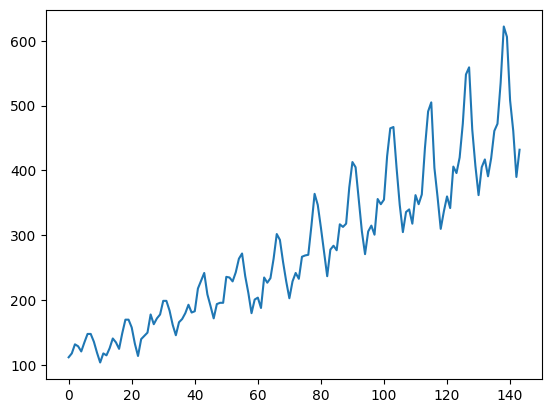

In [2]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [3]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [4]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


C:\Users\Steven\AppData\Local\Temp\ipykernel_10120\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.5255, test RMSE 422.9537
Epoch 100: train RMSE 191.0501, test RMSE 385.8916
Epoch 200: train RMSE 159.5620, test RMSE 352.1694
Epoch 300: train RMSE 131.5975, test RMSE 320.9113
Epoch 400: train RMSE 108.1114, test RMSE 292.5497
Epoch 500: train RMSE 89.5715, test RMSE 267.0179
Epoch 600: train RMSE 73.2179, test RMSE 242.7907
Epoch 700: train RMSE 59.5773, test RMSE 219.8443
Epoch 800: train RMSE 48.9690, test RMSE 199.0069
Epoch 900: train RMSE 40.8527, test RMSE 180.2616
Epoch 1000: train RMSE 35.9577, test RMSE 164.0470
Epoch 1100: train RMSE 30.9902, test RMSE 149.8292
Epoch 1200: train RMSE 29.6448, test RMSE 137.7250
Epoch 1300: train RMSE 27.2340, test RMSE 128.4944
Epoch 1400: train RMSE 25.4227, test RMSE 121.6389
Epoch 1500: train RMSE 25.4917, test RMSE 116.2059
Epoch 1600: train RMSE 25.8960, test RMSE 112.1262
Epoch 1700: train RMSE 23.8813, test RMSE 107.4804
Epoch 1800: train RMSE 24.0272, test RMSE 103.7811
Epoch 1900: train RMSE 24.1556, test R

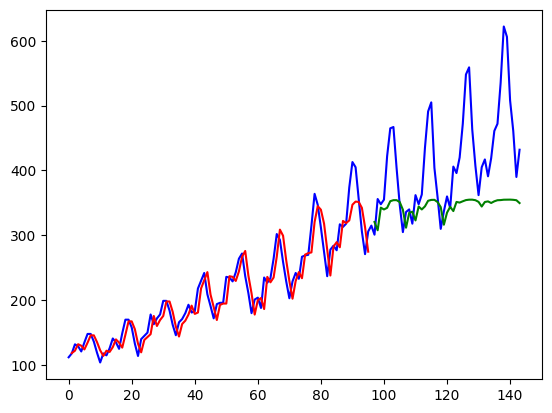

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

Epoch 0: train RMSE 225.5104, test RMSE 424.7174
Epoch 100: train RMSE 174.3063, test RMSE 370.9457
Epoch 200: train RMSE 135.9902, test RMSE 328.7170
Epoch 300: train RMSE 105.8788, test RMSE 292.0871
Epoch 400: train RMSE 82.7146, test RMSE 258.7071
Epoch 500: train RMSE 63.3549, test RMSE 227.7090
Epoch 600: train RMSE 50.0138, test RMSE 200.9142
Epoch 700: train RMSE 40.5323, test RMSE 177.3500
Epoch 800: train RMSE 34.0950, test RMSE 157.0723
Epoch 900: train RMSE 29.5604, test RMSE 139.6144
Epoch 1000: train RMSE 26.4898, test RMSE 124.8415
Epoch 1100: train RMSE 24.3535, test RMSE 112.7700
Epoch 1200: train RMSE 23.3737, test RMSE 103.4838
Epoch 1300: train RMSE 22.7088, test RMSE 96.9259
Epoch 1400: train RMSE 21.4881, test RMSE 90.5851
Epoch 1500: train RMSE 20.8544, test RMSE 86.0244
Epoch 1600: train RMSE 20.2971, test RMSE 82.6108
Epoch 1700: train RMSE 19.9398, test RMSE 79.0943
Epoch 1800: train RMSE 19.6479, test RMSE 78.5219
Epoch 1900: train RMSE 19.3121, test RMSE 75.

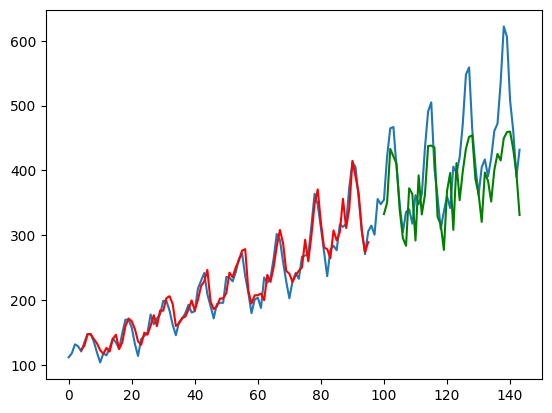

In [9]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()